In [46]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 100000
ensemble[0].beam.set_base_beam(
    ensemble[0].beam.base_dist,
    n_particles,
    p0c=torch.tensor(10.0e6)
)

ensemble.cuda();

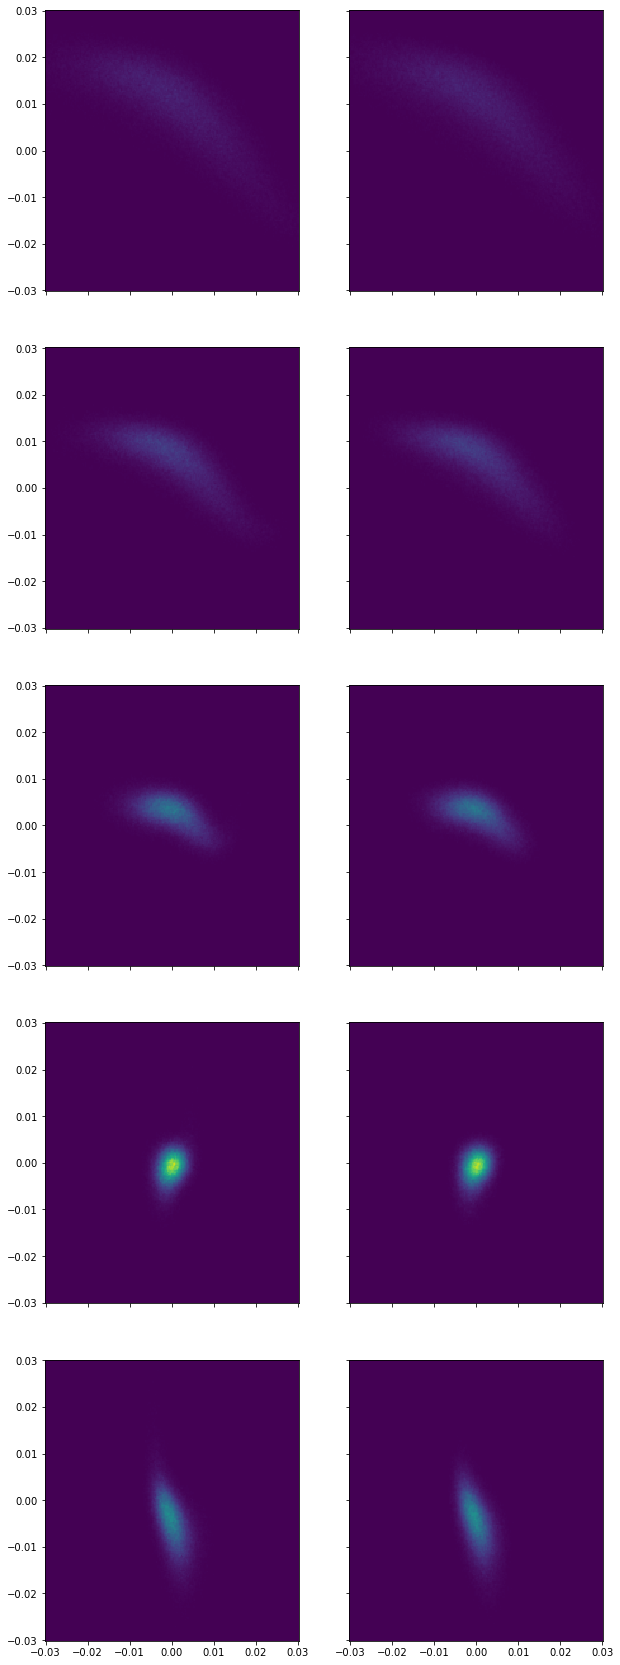

In [47]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](train_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx, train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.003
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.003)

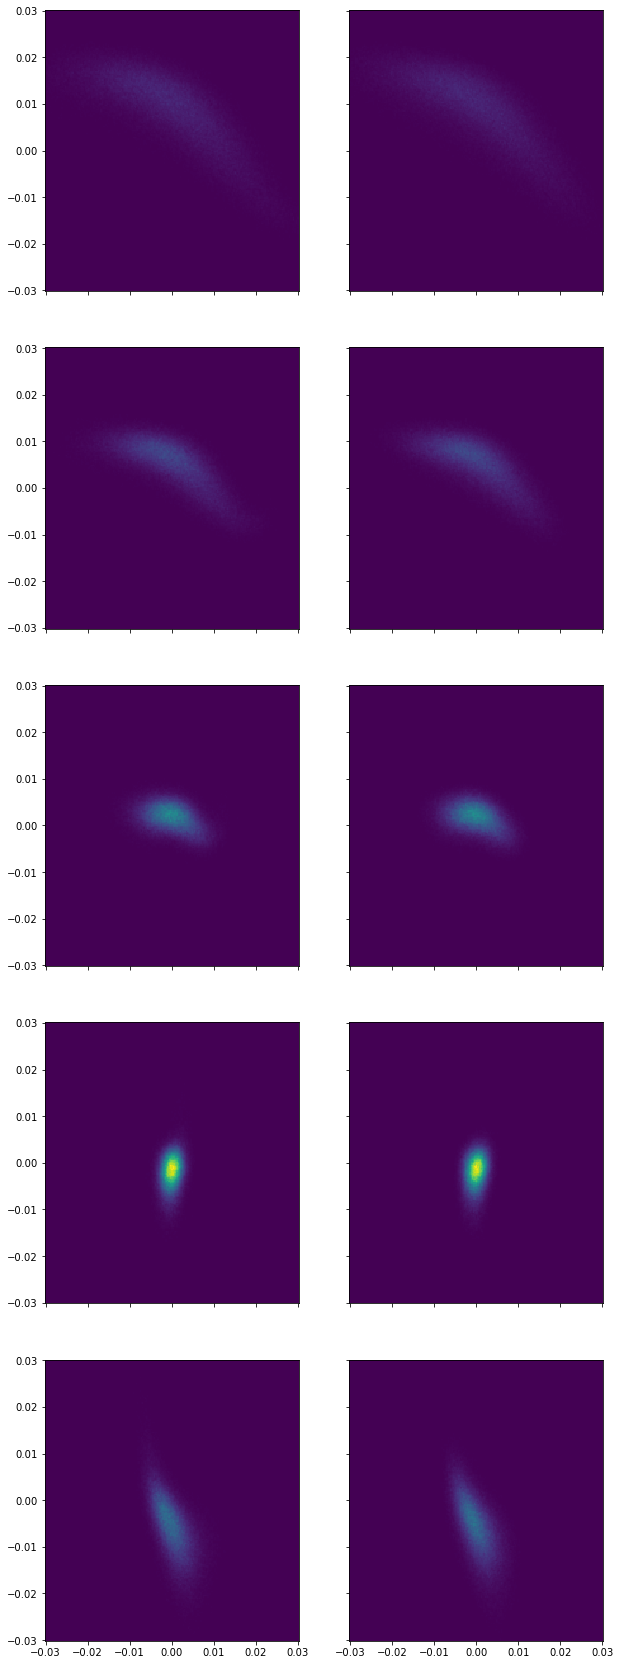

In [48]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy, cov = ensemble[-1](test_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx,test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.003
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.003)

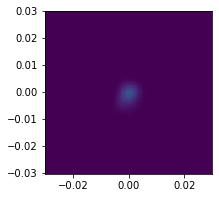

In [49]:
# zero quad strength
with torch.no_grad():
    predictions, entropy, cov = ensemble[0](torch.zeros(1,1).cuda())

fig,ax = plt.subplots()
fig.set_size_inches(3,3)
ax.pcolor(*xx,predictions[0].cpu().detach(), vmin=0,vmax=0.01)


In [50]:
# plot loss record
traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
covs = torch.stack([ele[1] for ele in traces])



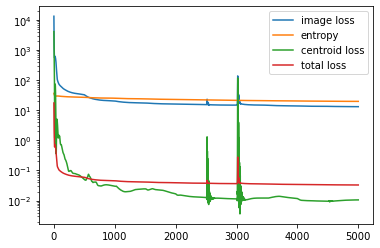

In [51]:
plt.semilogy(
    losses, label=["image loss","entropy","centroid loss","total loss"]
)
plt.legend()

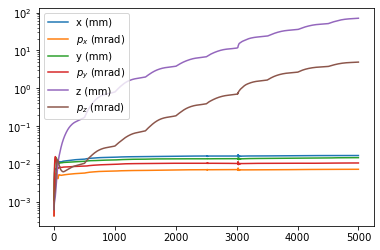

In [52]:
# plot convergence
moments = torch.diagonal(covs, dim1=-2,dim2=-1)

plt.semilogy(moments.cpu().detach()*1e3,label=labels)
plt.legend()

In [53]:
initial_beam = ensemble[-1].beam()


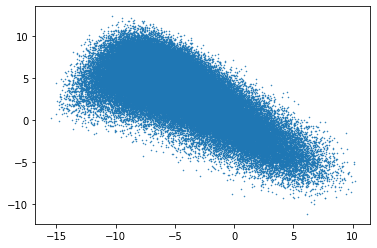

In [54]:
# propagate particles w/quad off
initial_y = initial_beam.y.cpu().detach().numpy()*1e3
initial_py = initial_beam.py.cpu().detach().numpy()*1e3

# distances
dist_to_slits = 3.38 - 2.84 + 0.12/2.0
dist_to_screen = 3.38 + 0.12/2.0

# particles
slits_y = initial_y + initial_py * dist_to_slits
slits_py = initial_py

screen_y = initial_y + initial_py * dist_to_screen
screen_py = initial_py

fig,ax=plt.subplots()
ax.plot(
    initial_y,
    initial_py,
    '.',ms=1
)

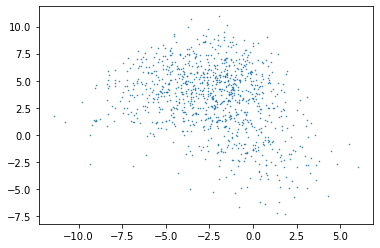

In [55]:
fig,ax=plt.subplots()
ax.plot(
    slits_y[::100], slits_py[::100],
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

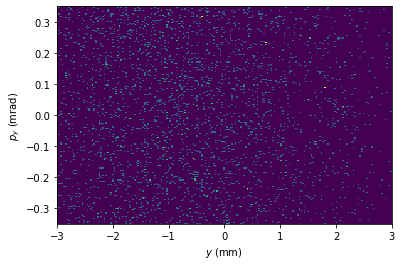

In [56]:
fig,ax=plt.subplots()
import numpy as np
# create a mesh
x = np.linspace(-3,3,200)
y = np.linspace(-0.35,0.35,200)

h, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x,y])
#xc = (xe[:-1] + xe[1:]) / 2
#yc = (ye[:-1] + ye[1:]) / 2
X, Y = np.meshgrid(xe,ye)

ax.pcolor(X, Y, h.T)
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

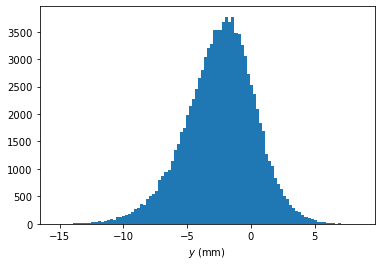

In [57]:
fig,ax=plt.subplots()
ax.hist(
    slits_y, bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

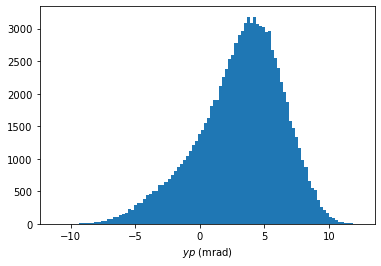

In [58]:
fig,ax=plt.subplots()
ax.hist(
    slits_py, bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [59]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 1.6805e-05, -9.4053e-06,  1.2686e-05, -8.6668e-06, -2.2253e-04,
         -2.0610e-05],
        [-9.4053e-06,  7.2757e-06, -7.2834e-06,  5.0888e-06,  1.3621e-04,
          1.7272e-05],
        [ 1.2686e-05, -7.2834e-06,  1.4751e-05, -9.2209e-06, -1.5280e-04,
         -4.9764e-05],
        [-8.6668e-06,  5.0888e-06, -9.2209e-06,  1.0677e-05,  1.6903e-04,
          3.3504e-05],
        [-2.2253e-04,  1.3621e-04, -1.5280e-04,  1.6903e-04,  7.0904e-02,
          1.4313e-03],
        [-2.0610e-05,  1.7272e-05, -4.9764e-05,  3.3504e-05,  1.4313e-03,
          4.9227e-03]], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [60]:
xcov = cov[:2,:2]
emit = torch.det(xcov).sqrt()
twiss = xcov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 5.814407813886646e-06
beta 2.890230655670166
alpha 1.617592692375183
gamma 1.2513210773468018


In [61]:
ycov = cov[2:4,2:4]
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 8.513044122082647e-06
beta 1.7327871322631836
alpha 1.083153486251831
gamma 1.2541768550872803


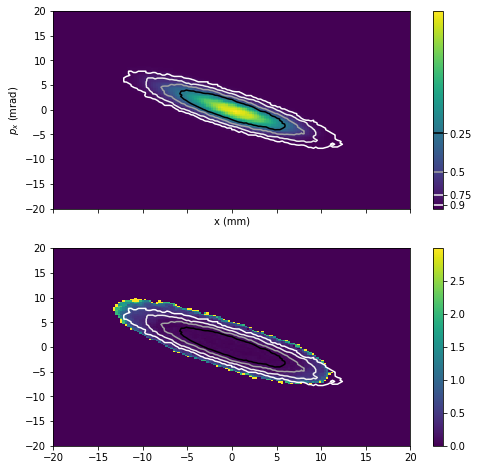

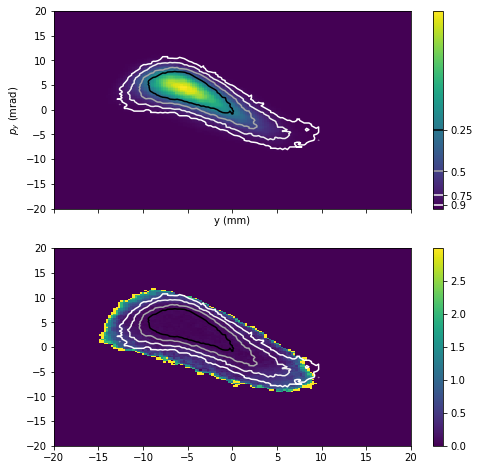

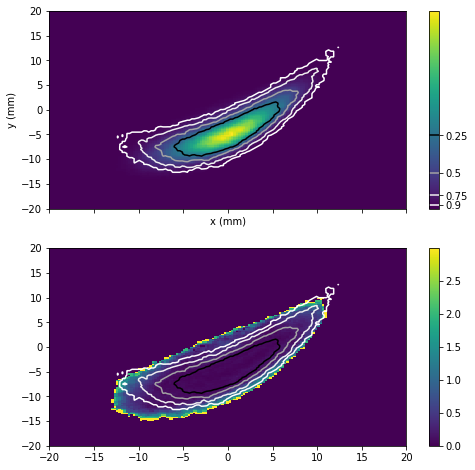

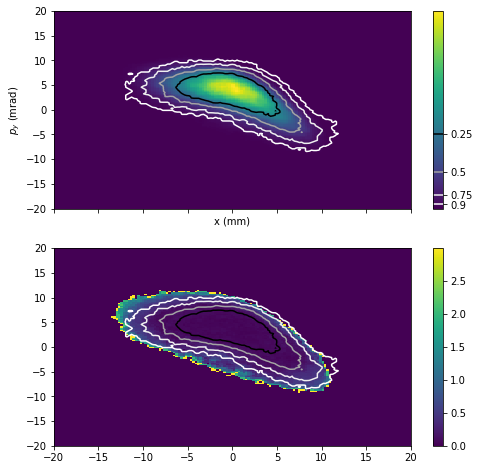

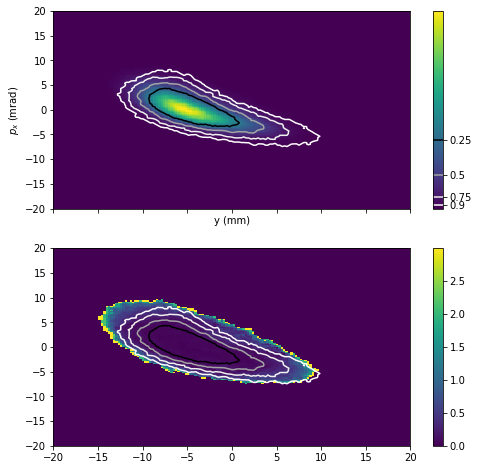

In [62]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter

fpath = ""

beam_coords = torch.load("synthetic_beam/ground_truth_dist.pt")



pairs = [[0,1],[2,3],[0,2],[0,3],[2,1]]
for pair in pairs:
    meas_x = beam_coords[:,pair[0]].detach().cpu().numpy()*1e3
    meas_y = beam_coords[:,pair[1]].detach().cpu().numpy()*1e3

    x1 = np.linspace(-20,20,150)
    x2 = np.linspace(-20,20,150)

    h_slitscan, xe, ye = np.histogram2d(meas_x, meas_y, bins=[x1,x2], density=True)

    reconstruction_images = []
    for i in range(10):
        initial_beam = ensemble[i].beam()
        reconstruction_coords = initial_beam.data

        reconstruct_x = reconstruction_coords[:,pair[0]].detach().cpu().numpy()*1e3
        reconstruct_y = reconstruction_coords[:,pair[1]].detach().cpu().numpy()*1e3

        h_reconstruction, xe, ye = np.histogram2d(reconstruct_x, reconstruct_y,
                                              bins=[x1,x2], density=True)
        h_reconstruction = median_filter(h_reconstruction, 3)
        reconstruction_images += [h_reconstruction]

    reconstruction_mean = np.array(reconstruction_images).mean(axis=0)
    reconstruction_std = np.array(reconstruction_images).std(axis=0)

    fig,ax=plt.subplots(2,1,sharey="all",sharex="all")
    fig.set_size_inches(8,8)

    # apply median filter
    #h_reconstruction = median_filter(h_reconstruction, 3)
    h_slitscan = median_filter(h_slitscan,3)

    # get cdf of densities
    test_levels = np.linspace(0, h_slitscan.max(), 1000)
    # for each level calculate the sum
    total = h_slitscan.sum()
    vmax = h_slitscan.max()
    sums = []
    for ele in test_levels:
        sums += [(h_slitscan - ele).clip(0).sum() / total]
    sums = np.array(sums)

    # calculate levels
    qunatiles = [0.25,0.5,0.75,0.9]
    levels = []
    for ele in qunatiles[::-1]:
        diff = sums - ele
        levels += [test_levels[np.where(np.diff(np.sign(diff)))]]

    x1c = (xe[:-1] + xe[1:]) / 2
    x2c = (ye[:-1] + ye[1:]) / 2

    X, Y = np.meshgrid(xe,ye)
    Xc, Yc = np.meshgrid(x1c,x2c)

    d = [reconstruction_mean,reconstruction_std / (reconstruction_mean + 1e-8)]
    for i in range(2):#zip(ax, [reconstruction_mean,reconstruction_std]):
        c1 = ax[i].pcolor(X, Y, d[i].T)
        #ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
        clevels = np.array(levels).flatten()
        c2 = ax[i].contour(Xc, Yc, h_slitscan.T, levels=clevels,cmap="Greys")

        cbar = fig.colorbar(c1,ax=ax[i])
        if i==0:
            cbar.set_ticks(clevels)
            cbar.set_ticklabels(qunatiles[::-1])
            cbar.add_lines(c2)
    # add ellipse
    #ax.add_patch(confidence_ellipse(ycov.cpu().detach().numpy(),1.0e3,edgecolor='red'))

    ax[0].set_xlabel(labels[pair[0]])
    ax[0].set_ylabel(labels[pair[1]])
#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)

In [63]:
# do core analysis
initial_data = initial_beam.data[:,2:4].cpu()

# sort by distance from origin in 4D phase space
initial_norm = torch.norm(initial_data, dim=-1)
initial_data_sorted = initial_data[torch.argsort(initial_norm),:]


geo_emit: 7.638580427737907e-06
norm emit: 0.0009417427936568856
beta 1.6730084419250488
alpha 1.0849273204803467
gamma 1.3012889623641968


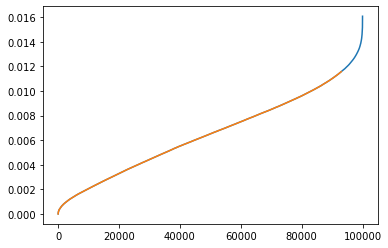

In [64]:
# get cov/emit of 95%
frac = 0.93
partial = initial_data_sorted[:int(initial_data_sorted.shape[0]*frac)]
cov = torch.cov(partial.T)

plt.plot(torch.norm(initial_data_sorted, dim=-1).detach().numpy())
plt.plot(torch.norm(partial, dim=-1).detach().numpy())

emit = torch.det(cov).sqrt()
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

twiss = cov / emit
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")